# XIA

## Preamplifier: charge to voltage

The electric charge generated in a solid state detector by an incident photon, is integrated by a reset-type preamplifier to produce an output voltage in which the X-ray events are visible as steps. A capacitor discharged is frequently needed and is visible as a jump.
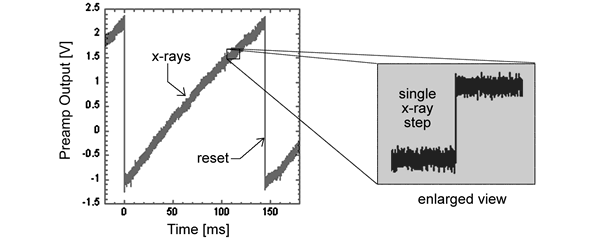

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spectrocrunch.utils import units

Function that converts X-ray energy to a preamplifier voltage step:

In [2]:
def fanonoise(n,factor):
    # TODO: use proper pdf
    if n<=0:
        return 0
    else:
        m = np.random.poisson(lam=n)
        return n + (m-n)*factor

def energytovoltage(energies,fanofactor=0.115):
    energies = units.Quantity(energies,'keV')
    ehole = units.Quantity(3.8,'eV')
    e = units.Quantity(1,'e')
    ne = (energies/ehole).to('dimensionless').magnitude
    ne = np.asarray(ne)
    # Fano noise
    if fanofactor:
        try:
            ne = units.Quantity([fanonoise(n,fanofactor) for n in ne],'dimensionless')
        except TypeError:
            ne = units.Quantity(fanonoise(ne,fanofactor),'dimensionless')
    cf = units.Quantity(0.002,'pF')
    return (ne*e/cf).to('V')

def voltagetoenergy(voltage):
    voltage = units.Quantity(voltage,'V')
    ehole = units.Quantity(3.8,'eV')
    cf = units.Quantity(0.002,'pF')
    e = units.Quantity(1,'e')
    energies = voltage*(cf/e*ehole)
    return energies.to('keV')

Function to simulate preamplifier events based on a Poissonian X-ray source with a particular energy spectrum defined by an expected energy and count rate (assume lines have a Lorentzian energy distribution):

In [3]:
def xrays_sample(avgenergies,avgrates,avgtime):
    tunit = 's'
    eunit = 'keV'
    Vunit = 'V'
    hunit = 'Hz'
    
    avgrates = units.Quantity(avgrates,hunit)
    avgtime = units.Quantity(avgtime,tunit)
    events = avgtime*avgrates
    events = events.to('dimensionless').astype(int)

    # Natural line width (in principle energy dependent)
    avgenergies = units.Quantity(avgenergies,eunit)
    energystd = units.Quantity(4,'eV')
    
    emag = lambda x: x.to(eunit).magnitude
    hmag = lambda x: x.to(hunit).magnitude
    vmag = lambda x: x.to(Vunit).magnitude
    ev_time = []
    ev_step = []
    for avgrate,avgenergy,n in zip(avgrates,avgenergies,events):
        # Poisson source
        time_periods = np.random.exponential(scale=1.0/hmag(avgrate), size=n)
        ev_time += time_periods.cumsum().tolist()
        # Lorentzian spectral lines
        ev_energy = emag(avgenergy) + np.random.standard_cauchy(size=n)*emag(energystd)
        # Energy to voltage (fano noise)
        ev_volt = energytovoltage(units.Quantity(ev_energy,eunit))
        ev_step += ev_volt.tolist()

    ev_time, ev_step = zip(*sorted(zip(ev_time, ev_step)))
    ev_time = units.Quantity(ev_time,'1/'+hunit).to(tunit)
    ev_step = units.Quantity(ev_step,Vunit)
    
    return ev_time,ev_step

Function to simulate a preamplifier output:

In [4]:
def preamp_sample(ev_time,ev_step,samplefreq):
    samplefreq = units.Quantity(samplefreq,'Hz')
    samplebin = 1./samplefreq
    n = int(np.ceil(((max(ev_time)/samplebin).to('dimensionless').magnitude)))+1
    time = samplebin * np.arange(n)
    
    # Gaussian electronic noise
    estd = units.Quantity(120/(2*np.sqrt(2*np.log(2))),'eV')
    ampstd = energytovoltage(estd,fanofactor=0)
    ampstd = units.Quantity(np.random.normal(scale=ampstd.magnitude,size=n),ampstd.units)
    
    # Preamplifier resets
    ampmax = units.Quantity(3,'V')
    steps = ev_step.cumsum()
    nresets = np.ceil((steps/ampmax).to('dimensionless').magnitude)
    steps -= (nresets.astype(int)-1)*ampmax
    
    # Sample step function
    def pointwise(x):
        ind = np.where(x>=ev_time)[0]
        if ind.size==0:
            return units.quantity_like(0,steps)
        else:
            return steps[ind[-1]]
    ampout = units.asqarray(map(pointwise,time))
    
    return time,ampout,ampstd

Simulate preamplifier output:

In [5]:
avgenergies = units.Quantity([4.,7],'keV')
avgrates = units.Quantity([1.,2],'MHz')
ev_time,ev_step = xrays_sample(avgenergies,avgrates,units.Quantity(300,'us'))
time,ampout,ampstd = preamp_sample(ev_time,ev_step,units.Quantity(50,'MHz'))
signal = ampout+ampstd

Plot preamplifier output histogram (without pulse processing, so without electronic noise):

/mntdirect/_data_id21_inhouse/wout/dev/virtualenvs/rnice8/spectrocrunch/py27/local/lib/python2.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Expected:
4.0 keV: 1.0 MHz
7.0 keV: 2.0 MHz
Fitted:
4.00141114899 keV (sigma=16.6434218125 eV): 0.90894218001 MHz
6.99918132608 keV (sigma=21.0012397434 eV): 1.88920220887 MHz


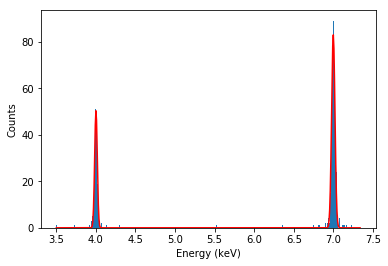

In [6]:
from spectrocrunch.math.distributions import plothistogram
from silx.math.fit.functions import sum_gauss
from silx.math.fit import fittheories
from silx.math.fit.fitmanager import FitManager

#samples = ev_step.to('mV')
samples = voltagetoenergy(ev_step)
y,edges = np.histogram(samples,bins=500)

x = plothistogram(y,edges=edges)
binsize = np.median(np.diff(x))

ax = plt.gca()
xlabel = ax.set_xlabel('Energy ({:~})'.format(samples.units))
ylabel = ax.set_ylabel('Counts')

try:
    samples.to('keV')
    bfit = True
except:
    bfit = False

if bfit:
    fit = FitManager()
    fit.setdata(x=x, y=y)
    fit.loadtheories(fittheories)
    fit.settheory('Gaussians')
    fit.setbackground('No Background')
    fit.estimate()
    fit.runfit()
    yfit = fit.gendata()
    lines = plt.plot(x,yfit,color='r')
    #ax = lines[0].axes
    #lim = avgenergies.to(samples.units).magnitude
    #d = lim[-1]-lim[0]
    #ax.set_xlim(lim[0]-0.8*d,lim[-1]+1.2*d)
    
    params = np.array(fit.get_fitted_parameters())
    params = params.reshape((params.size//3,3))
    height,position,FWHM = params.T
    position = units.quantity_like(position,samples)
    area = height*FWHM*np.sqrt(np.pi/(4*np.log(2)))/binsize
    FWHM = units.quantity_like(FWHM,samples)
    sigma = FWHM/(2*np.sqrt(2*np.log(2)))
    rate = area/max(time)
    print('Expected:')
    for e,r in zip(avgenergies.to('keV'),avgrates.to('MHz')):
        print('{:~}: {:~}'.format(e,r))
    print('Fitted:')
    for e,r,s in zip(position.to('keV'),rate.to('MHz'),sigma.to('eV')):
        print('{:~} (sigma={:~}): {:~}'.format(e,s,r))

Plot preamplifier output (signal used for pulse processing):

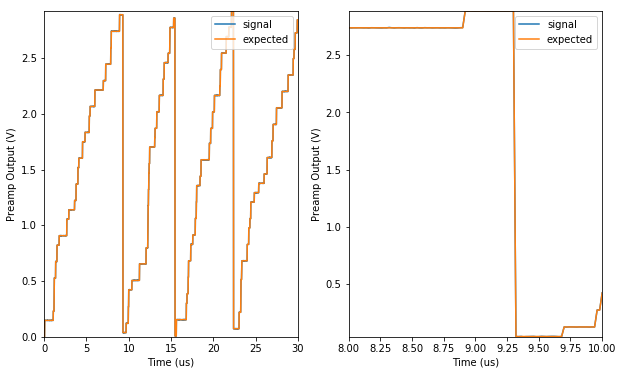

In [7]:
time = time.to('us')
signal = signal.to('V')
ampout = ampout.to('V')

fig,axs = plt.subplots(1,2,figsize=(10,6))

def xlim(ax,xmin,xmax):
    xmin,xmax = units.quantity_like(xmin,time),units.quantity_like(xmax,time)
    tmp = ax.set_xlim(xmin.magnitude,xmax.magnitude)
    visible_y = signal[(xmin < time) & (time < xmax)]
    if len(visible_y):
        tmp = ax.set_ylim(np.min(visible_y).magnitude,
                          np.max(visible_y).magnitude)

def preamp_plot(o,x,y,marker=None,label=None):
    lines = o.plot(x,y,marker=marker,label=label)
    ax = lines[0].axes
    xlabel = ax.set_xlabel('Time ({:~})'.format(x.units))
    ylabel = ax.set_ylabel('Preamp Output ({:~})'.format(y.units))
    return ax

for i in range(2):
    ax = axs[i]
    tmp = preamp_plot(ax,time,signal,label='signal')
    ax.plot(time,ampout,label='expected')
    ax.legend()
    
xlim(axs[0],0,30)
xlim(axs[1],8,10)

## Digital pulse processor
When detecting events from a random process, a pulse is generated for each event which has a finite time width $\tau$. Either pulses are rejected during this time period (non-extendable dead time) or overlapping pulses are counted as
one pulse (extendable dead time).

### Extendable dead time
Pulses which overlap (in the fast or slow channel) are counted as one. The measured count rate is related to the real count rate as
$$
r_{\text{meas}} = re^{-r\tau}
$$
where $\tau$ the dead time per event.

### Dead time fraction
The dead time fraction refers to the fraction of lost events during measurement
$$
\text{DT} = \frac{n-n_{\text{meas}}}{n}
$$

### Live time
The live time of the measurement is defined as the fraction of the measurement time $t$ in which events are detected
$$
t_{\text{live}} = t(1-\text{DT})
$$
The total dead time would be $t-t_{\text{live}}=t\text{DT}$.

### Other relationships
$$
\begin{align}
\text{DT} &= \frac{r-r_{\text{meas}}}{r} = \frac{t-t_{\text{live}}}{t}\\
1-\text{DT} & = \frac{r_{mean}}{r} = \frac{t_{live}}{t}\\
n_{\text{meas}}&=n(1-\text{DT})\\
r_{\text{meas}}&=r(1-\text{DT})\\
t_{\text{live}}&=te^{-r\tau}\\
\tau&=-\frac{\ln{(1-\text{DT})}}{r}\\
\text{DT}&=1-e^{-r\tau}
\end{align}
$$

### Dual channel
The preamplifier output is filtered by a Trapezoidal filter. This is done twice: fast (X-ray detection, small filter width), slow (energy filter, large filter width). The filter width is given by $2L+G$ where $G$ the gap time and $L$ the peaking time. Peaks in the fast channel are counted to obtain the real count rate (after dividing by the fast channel live time). Peaks in the slow channel are used to determine the X-ray energies. Peaks in the slow channel that appear as multiple peaks in the fast channel are rejected (pile-up rejection). Peak overlap in the fast channel cannot be detected and results in pile-up peaks in the XRF spectrum.

### XIA statistics
The XIA records these statistics for each detector:

 * $\text{NUM}$: detector number
 * $\text{EV} = n_{\text{slow}}$: number slow channel events (after pile-up rejection)
 * $\text{ICR} = r = \frac{n_{\text{fast}}}{t_{\text{fast}}}$: real count rate in hertz
 * $\text{OCR} = \frac{n_{\text{slow}}}{t}$: slow channel count rate in hertz
 * $\text{LT} = t_{\text{fast}}$: fast channel live time in milliseconds
 * $\text{DT}$: dead time in percentage

Based on these statistics, the real counts can be derived from the measured counts in the slow channel
$$
n=n_{\text{slow}}\frac{\text{ICR}}{\text{OCR}}
$$

Filter width: 2 samples, 0.04 us
Filter width: 13 samples, 0.26 us


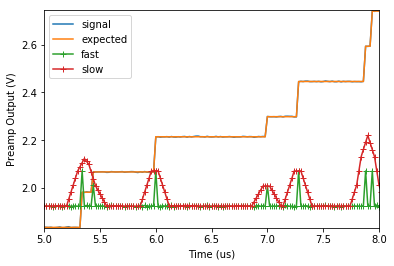

In [8]:
time = time.to('us')
signal = signal.to('V')
ampout = ampout.to('V')

def trapfilter(G,L):
    dt = time[1]-time[0]
    L = max(int(np.ceil(L/dt)),1)
    G = max(int(np.ceil(G/dt)),0)
    print('Filter width: {} samples, {:~}'.format((2*L+G),(2*L+G)*dt))
    return np.concatenate([np.ones(L)/float(L),np.zeros(G),-np.ones(L)/float(L)])

G = units.Quantity(0,'ns')
L = units.Quantity(5,'ns')
wfast = trapfilter(G,L)

G = units.Quantity(0.05,'us')
L = units.Quantity(0.1,'us')
wslow = trapfilter(G,L)

sfast = np.convolve(signal.magnitude,wfast,'same')
sslow = np.convolve(signal.magnitude,wslow,'same')
sfast = units.Quantity(sfast,signal.units)
sslow = units.Quantity(sslow,signal.units)

ax = preamp_plot(plt,time,signal,label='signal')
ax = preamp_plot(plt,time,ampout,label='expected')
xlim(ax,5,8)
ylim = ax.get_ylim()
add = units.quantity_like(ylim[0]+(ylim[1]-ylim[0])*0.1,sfast)
sfast += add
sslow += add
ax = preamp_plot(ax,time,sfast,label='fast',marker='+')
ax = preamp_plot(ax,time,sslow,label='slow',marker='+')
tmp = ax.legend()

## XIA EDF output

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from spectrocrunch.io import xiaedf

path = '/data/id21/store/backup_visitor/2018/ev280/id21/fe2streptor2/fe2streptor2_main_root/zap'
radix = 'fe2streptor2_main_root'
num = 1

xiaimage = xiaedf.xiaimage_number(path,radix,num)
xiaimage.dtcor(False)
xiaimage.detectorsum(False)
xiaimage.counter_reldir('.')

### DXP statistics

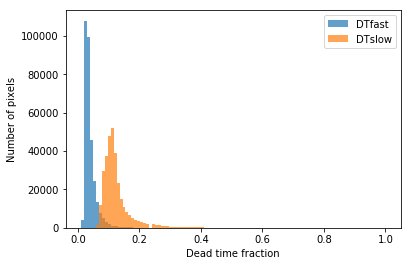

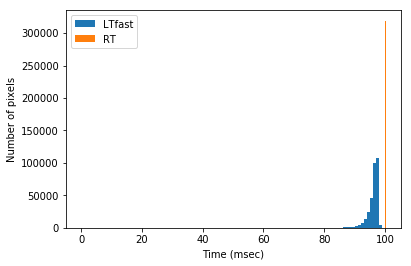

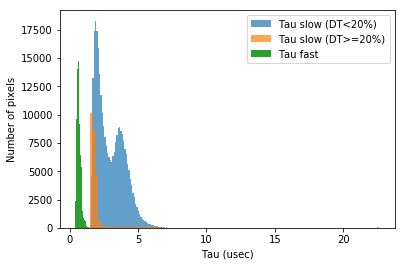

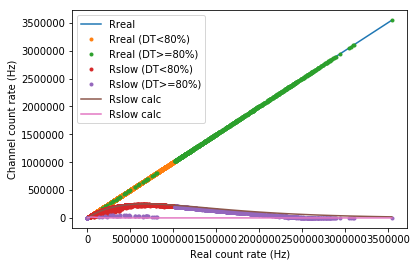

In [22]:
from spectrocrunch.math.distributions import plothistogram
import scipy.optimize

xiaimage.onlyicrocr(False)

stats = xiaimage.stats.astype(float)
Nslow = stats[...,xiaimage.STEVT,0]
Rreal = stats[...,xiaimage.STICR,0]
Rslow = stats[...,xiaimage.STOCR,0]
LTfast = stats[...,xiaimage.STLT,0]/1000.
DTslow = stats[...,xiaimage.STDT,0]/100.

# Dead time fraction
maskDT100 = Rreal==0
with np.errstate(divide='ignore', invalid='ignore'):
    RT = Nslow/Rslow
    DT = (Rreal-Rslow)/Rreal
DT[maskDT100] = 1
RT[maskDT100] = 0.1
DTfast = 1-LTfast/RT
np.testing.assert_array_almost_equal(DTslow, DT, decimal=2) 

# Dead time per event
with np.errstate(divide='ignore', invalid='ignore'):
    tauslow = -(1-DT)*np.log(1-DT)/Rslow
    taufast = -np.log(LTfast/RT)/Rreal
mask = DT<1
tauslow[~mask] = tauslow[mask].max()
mask = np.isfinite(taufast)
taufast[~mask] = taufast[mask].max()

tmp = plothistogram(*np.histogram(DTfast,bins=100),alpha=0.7,label='DTfast')
tmp = plothistogram(*np.histogram(DTslow,bins=100),alpha=0.7,label='DTslow')
ax = plt.gca()
tmp = ax.set_xlabel('Dead time fraction')
tmp = ax.set_ylabel('Number of pixels')
tmp = ax.legend()
#tmp = ax.set_yscale('log')

plt.figure()
tmp = plothistogram(*np.histogram(LTfast*1000,bins=100),label='LTfast')
tmp = plothistogram(*np.histogram(RT*1000,bins=5),label='RT')
ax = plt.gca()
tmp = ax.set_xlabel('Time (msec)')
tmp = ax.set_ylabel('Number of pixels')
tmp = ax.legend()

plt.figure()
mask = DTslow < 0.2
tmp = plothistogram(*np.histogram(tauslow[mask]*1e6,bins=100),alpha=0.7,label='Tau slow (DT<20%)')
tmp = plothistogram(*np.histogram(tauslow[~mask]*1e6,bins=100),alpha=0.7,label='Tau slow (DT>=20%)')
tmp = plothistogram(*np.histogram(taufast*1e6,bins=100),label='Tau fast')
ax = plt.gca()
tmp = ax.set_xlabel('Tau (usec)')
tmp = ax.set_ylabel('Number of pixels')
tmp = ax.legend()

plt.figure()
tmp = plt.plot([Rreal.min(), Rreal.max()], [Rreal.min(), Rreal.max()], label='Rreal')
mask = DTslow < 0.8
tmp = plt.plot(Rreal[mask].flatten(), Rreal[mask].flatten(), '.', label='Rreal (DT<80%)')
tmp = plt.plot(Rreal[~mask].flatten(), Rreal[~mask].flatten(), '.', label='Rreal (DT>=80%)')
tmp = plt.plot(Rreal[mask].flatten(), Rslow[mask].flatten(), '.', label='Rslow (DT<80%)')
tmp = plt.plot(Rreal[~mask].flatten(), Rslow[~mask].flatten(), '.', label='Rslow (DT>=80%)')
x = np.linspace(Rreal.min(), Rreal.max(), 100)
y = x*np.exp(-x*tauslow.min())
tmp = plt.plot(x, y, label='Rslow calc')
y = x*np.exp(-x*tauslow.max())
tmp = plt.plot(x, y, label='Rslow calc')
ax = plt.gca()
tmp = ax.set_xlabel('Real count rate (Hz)')
tmp = ax.set_ylabel('Channel count rate (Hz)')
tmp = ax.legend()

### XRF spectra

In [23]:
from spectrocrunch.io import spec
from spectrocrunch.instruments.configuration import factory
import spectrocrunch
xiaimage.dtcor(True)
xiaimage.detectorsum(True)
xiaimage.exclude_detectors = ['S0']
mca = xiaimage.data[...,0]

counters = xiaimage.counterbasenames()
h = xiaimage.header(source=counters[0])
instrument = factory('id21')

kwargs = {'energy':instrument.edfheaderkeys['energylabel'],
          'speclabel':instrument.edfheaderkeys['speclabel'],
          'compensationmotors':instrument.compensationmotors,
          'units':instrument.units}
parser = spec.edfheader_parser(**kwargs)
info = parser(h)

Sum all channels and detectors:

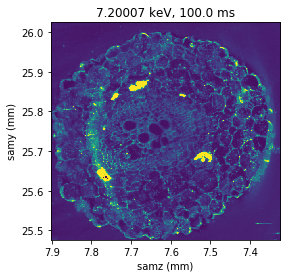

In [12]:
mcasum = mca.sum(axis=-1)
tmp = plt.imshow(mcasum)
ax0,ax1 = info['axes']
title = '{:~}, {:~}'.format(info['energy'],info['time'])

def imshow(ax,image,ax0,ax1,rlo=0,rhi=1,aspect=None,**kwargs):
    d0 = ax0.stepsize
    d1 = ax1.stepsize
    y0 = ax0.start+d0*0.5
    y1 = ax0.end-d0*0.5
    x0 = ax1.start+d1*0.5
    x1 = ax1.end-d1*0.5
    if aspect:
        aspectratio_data = ((y1-y0)/(x1-x0)).to('dimensionless').magnitude
        aspect = aspect/np.abs(aspectratio_data)
    extent = (x0.magnitude,x1.magnitude,y0.magnitude,y1.magnitude)
    mi,ma = np.nanmin(image),np.nanmax(image)
    d = ma-mi
    mi,ma = mi+rlo*d,mi+rhi*d
    image = (image-mi)/(ma-mi)
    image = np.clip(image,0,1)
    img = ax.imshow(image, interpolation = 'nearest',
                    extent = extent, origin = 'lower',
                    aspect = aspect, **kwargs)
    ax = img.axes
    ax.set_xlabel(str(ax0))
    ax.set_ylabel(str(ax1))
    return ax

ax = imshow(plt,mcasum,ax0,ax1,rhi=0.1)
tmp = ax.set_title(title)

Select pixels for statistical analysis:

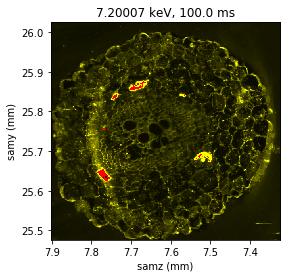

In [13]:
from skimage.filters import threshold_otsu

img = mcasum.copy()
imgsel = img.copy()
mi = img.min()

if True:
    mask = (DT>0.05) & (DT<0.8)
else:
    img[DT>0.5] = mi
    thres = threshold_otsu(img)
    mask = img >= thres

imgsel[~mask] = np.nan
rgb = np.stack([img,imgsel,img*0],axis=-1)
ax = imshow(plt,rgb,ax0,ax1,rhi=0.1)
tmp = ax.set_title(title)

Non-Negative Matrix Factorization of selected spectra:

In [14]:
from sklearn import decomposition
from numpy.random import RandomState
from scipy.sparse import csr_matrix
from spectrocrunch.utils.timing import timeit

nrow,ncol,nchan = mca.shape
nsamples = nrow*ncol
nfeatures = nchan

with timeit('NMF'):
    model = decomposition.NMF(n_components=3, init='random',
                              random_state=RandomState(0))
    #data = csr_matrix(mca.reshape((nsamples,nfeatures)))
    data = csr_matrix(mca[mask,...])
    coefficients = model.fit_transform(data).T

Execution time (NMF): 144.107053995


Each XRF spectrum is a linear combination of the NMF components. Plot the coefficients (images) and the components (vectors):

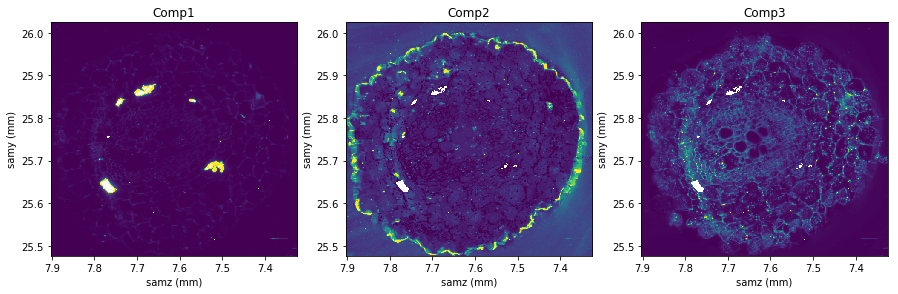

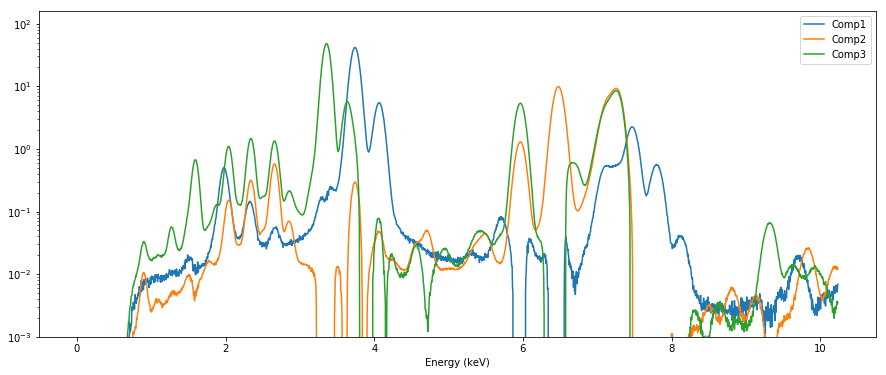

In [15]:
fig,axs = plt.subplots(1,model.n_components,figsize=(15,6))
eigenimage = np.full_like(mcasum,np.nan)
for i,coeff in enumerate(coefficients):
    ax = axs[i]
    eigenimage[mask] = coeff
    ax = imshow(ax,eigenimage,ax0,ax1,rhi=0.3)
    ax.set_title('Comp{}'.format(i+1))

plt.figure(figsize=(15,6))
mcabin = 5e-3
x = np.arange(nchan)*mcabin
for i,eigenvector in enumerate(model.components_):
    plt.plot(x,eigenvector,label='Comp{}'.format(i+1))
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(0.001,None)
ax.set_xlabel('Energy (keV)')
tmp = ax.legend()